In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from scipy.ndimage import median_filter
import sys
import os
import struct
import pywt
import concurrent.futures
import glob

sys.path.append(os.path.join(os.getcwd(), 'EC'))
sys.path.append(os.path.join(os.getcwd(), 'plotting'))
import constants
import Func_read_data
import Func_despike_data
import sensor_info
import Func_DR
import Func_MRFD
import Funcs_plots

importlib.reload(Func_read_data)
importlib.reload(Func_despike_data)
importlib.reload(constants)
importlib.reload(sensor_info)
importlib.reload(Func_DR)
importlib.reload(Func_MRFD)
importlib.reload(Funcs_plots)

from Func_read_data import *
from constants import *
from Func_despike_data import *
from sensor_info import *
from Func_MRFD import *
from Func_DR import *
from Funcs_plots import *

In [ ]:
folder = '/home/engbers/Documents/PhD/EC_data_convert/converted/'
sensor = 'SFC'
start = '2024-01-01 00:00'
end = '2025-03-01 00:00'
output_folder = '/home/engbers/Documents/PhD/EC_data_convert/SFC/202404'

# GET SENSOR INFO
plim, calibration_coefficients, heights = get_sensor_info(sensor, 2024)
slowdata = read_data(folder, 'slow', sensor, start, end, plot_data=False)

file_numbers_array = [i for i in range(502, 498, 6)]

def process_batch(file_number):
    file_numbers = np.arange(file_number, file_number + 8).astype(int).astype(str)
    print(f"Processing files: {file_numbers}")
    
    fastdata_SFC = read_data(folder, 'fast', sensor, start, end, file_numbers=file_numbers)
    
    despiked_fastdata = despike_fast_MAD(
        fastdata_SFC, slowdata, plim, sensor,
        calibration_coefficients=calibration_coefficients,
        plot_despike=False  # Set False if running parallel headless
    )
    
    save_despiked_data(fastdata_SFC, despiked_fastdata, output_folder, sensor)
    return f"Finished {file_number}"

# Run in parallel
with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    results = list(tqdm(executor.map(process_batch, file_numbers_array), total=len(file_numbers_array)))
print(results)

In [14]:
"""READ IN EDDYPRO FILES"""
folder='/home/engbers/Documents/PhD/EC_data_convert/'

sensor='SFC'
fluxes_SFC = read_eddypro_data(folder, sensor)
fluxes_SFC_qc = read_eddypro_data(folder, sensor, qc=True)
sensor='CSAT_16m'
fluxes_16m = read_eddypro_data(folder, sensor)
fluxes_16m_qc = read_eddypro_data(folder, sensor, qc=True)
sensor='CSAT_26m'
fluxes_26m_qc = read_eddypro_data(folder, sensor, qc=True)
fluxes_26m = read_eddypro_data(folder, sensor)
sensor='CSAT_26m_DR'
fluxes_26m_DR = read_eddypro_data(folder, sensor)

Files found: ['/home/engbers/Documents/PhD/EC_data_convert/SFC/EddyPro_output/202405/eddypro_SFC_May2024_full_output_2025-04-29T132516_adv.csv', '/home/engbers/Documents/PhD/EC_data_convert/SFC/EddyPro_output/202404/eddypro_SFC_Apr2024_full_output_2025-04-29T114218_adv.csv', '/home/engbers/Documents/PhD/EC_data_convert/SFC/EddyPro_output/202406/eddypro_SFC_June2024_full_output_2025-04-29T142426_adv.csv', '/home/engbers/Documents/PhD/EC_data_convert/SFC/EddyPro_output/202402/eddypro_SFC_Mar2024_full_output_2025-04-29T085353_adv.csv', '/home/engbers/Documents/PhD/EC_data_convert/SFC/EddyPro_output/202403/eddypro_SFC_Mar2024_full_output_2025-04-29T091527_adv.csv', '/home/engbers/Documents/PhD/EC_data_convert/SFC/202403/eddypro_SFC_Mar2024_full_output_2025-04-29T091527_adv.csv']


/home/engbers/Documents/Github/DataProcessingScripts/Func_read_data.py:424: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(file, header=1) for file in files],
/home/engbers/Documents/Github/DataProcessingScripts/Func_read_data.py:424: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(file, header=1) for file in files],
/home/engbers/Documents/Github/DataProcessingScripts/F

Files found: ['/home/engbers/Documents/PhD/EC_data_convert/SFC/EddyPro_output/202405/eddypro_SFC_May2024_qc_details_2025-04-29T132516_adv.csv', '/home/engbers/Documents/PhD/EC_data_convert/SFC/EddyPro_output/202404/eddypro_SFC_Apr2024_qc_details_2025-04-29T114218_adv.csv', '/home/engbers/Documents/PhD/EC_data_convert/SFC/EddyPro_output/202406/eddypro_SFC_June2024_qc_details_2025-04-29T142426_adv.csv', '/home/engbers/Documents/PhD/EC_data_convert/SFC/EddyPro_output/202402/eddypro_SFC_Mar2024_qc_details_2025-04-29T085353_adv.csv', '/home/engbers/Documents/PhD/EC_data_convert/SFC/EddyPro_output/202403/eddypro_SFC_Mar2024_qc_details_2025-04-29T091527_adv.csv', '/home/engbers/Documents/PhD/EC_data_convert/SFC/202403/eddypro_SFC_Mar2024_qc_details_2025-04-29T091527_adv.csv']
Files found: ['/home/engbers/Documents/PhD/EC_data_convert/CSAT_16m/EddyPro_output/202403/eddypro_16m_Mar2024_full_output_2025-04-29T095328_adv.csv']


/home/engbers/Documents/Github/DataProcessingScripts/Func_read_data.py:424: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(file, header=1) for file in files],


Files found: ['/home/engbers/Documents/PhD/EC_data_convert/CSAT_16m/EddyPro_output/202403/eddypro_16m_Mar2024_qc_details_2025-04-29T095328_adv.csv']
Files found: ['/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m/EddyPro_output/202405/eddypro_26m_May2024_qc_details_2025-05-19T132715_adv.csv', '/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m/EddyPro_output/202404/eddypro_26m_Apr2024_qc_details_2025-04-29T110745_adv.csv', '/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m/EddyPro_output/202403/eddypro_26m_Mar2024_qc_details_2025-04-29T101958_adv.csv']
Files found: ['/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m/EddyPro_output/202405/eddypro_26m_May2024_full_output_2025-05-19T132715_adv.csv', '/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m/EddyPro_output/202404/eddypro_26m_Apr2024_full_output_2025-04-29T110745_adv.csv', '/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m/EddyPro_output/202403/eddypro_26m_Mar2024_full_output_2025-04-29T101958_adv.csv']
Files foun

-16.635955476664115
-17.034646477446483


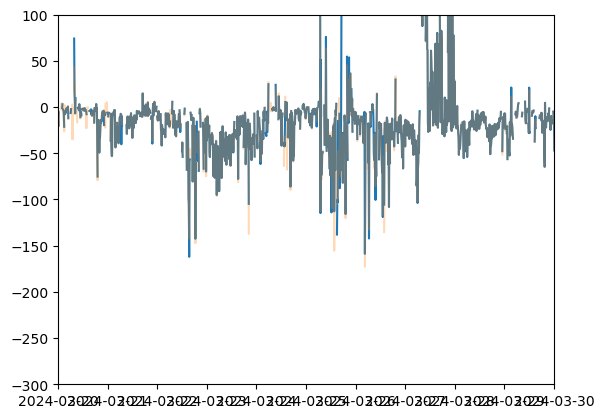

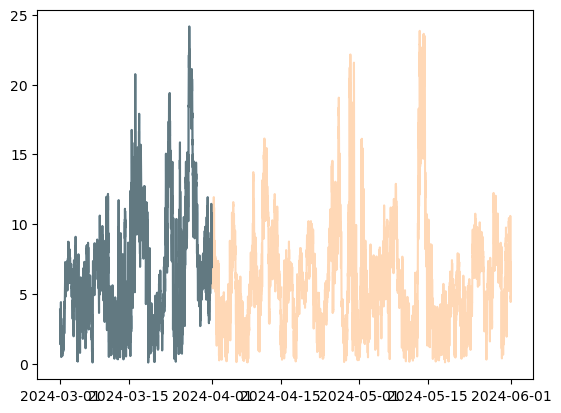

In [27]:
plt.figure()
plt.plot(fluxes_26m_DR['H'])
plt.plot(fluxes_26m['H'], alpha=0.3)
plt.ylim(-300,100)
plt.xlim(pd.Timestamp('2024-03-20 00:00'), pd.Timestamp('2024-03-30 00:00'))
print(np.mean(fluxes_26m_DR['H']['2024-03-20':'2024-03-30']))
print(np.mean(fluxes_26m['H']['2024-03-20':'2024-03-30']))

plt.figure()
plt.plot(fluxes_26m_DR['wind_speed'])
plt.plot(fluxes_26m['wind_speed'], alpha=0.3)

Using 2024 calibration coefficients
{'A': 4820.04, 'B': 3792900.0, 'C': -115477000.0, 'H2O_Zero': 0.7087, 'H20_Span': 0.9885}
Reading data from /home/engbers/Documents/PhD/EC_data_convert/converted/20240118_SFC
TOA5_STN1OneMin_403_2023_12_31_1506.dat
Extracted number: 403
TOA5_STN1OneMin_404_2024_01_01_1506.dat
Extracted number: 404
TOA5_STN1OneMin_405_2024_01_02_1506.dat
Extracted number: 405
TOA5_STN1OneMin_406_2024_01_03_1506.dat
Extracted number: 406
TOA5_STN1OneMin_407_2024_01_04_1506.dat
Extracted number: 407
TOA5_STN1OneMin_408_2024_01_05_1506.dat
Extracted number: 408
TOA5_STN1OneMin_409_2024_01_06_1506.dat
Extracted number: 409
TOA5_STN1OneMin_410_2024_01_07_1506.dat
Extracted number: 410
TOA5_STN1OneMin_411_2024_01_08_1506.dat
Extracted number: 411
TOA5_STN1OneMin_412_2024_01_09_1506.dat
Extracted number: 412
TOA5_STN1OneMin_413_2024_01_10_1506.dat
Extracted number: 413
TOA5_STN1OneMin_414_2024_01_11_1506.dat
Extracted number: 414
TOA5_STN1OneMin_415_2024_01_12_1506.dat
Extra

/home/engbers/Documents/Github/DataProcessingScripts/Func_read_data.py:287: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'./plots/{sensor}_{start}_slowdata.png', bbox_inches='tight')


(<Figure size 1300x1400 with 7 Axes>,
 array([<Axes: ylabel='Temperature [oC]'>, <Axes: ylabel='RH wrt ice [%]'>,
        <Axes: ylabel='Wind Direction'>, <Axes: ylabel='Wind Speed[ms-1]'>,
        <Axes: ylabel='Net Radiation [Wm-2]'>,
        <Axes: ylabel='Net Radiation [Wm-2]'>,
        <Axes: ylabel='Flowcapt [g/m2/s]'>], dtype=object))

/home/engbers/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


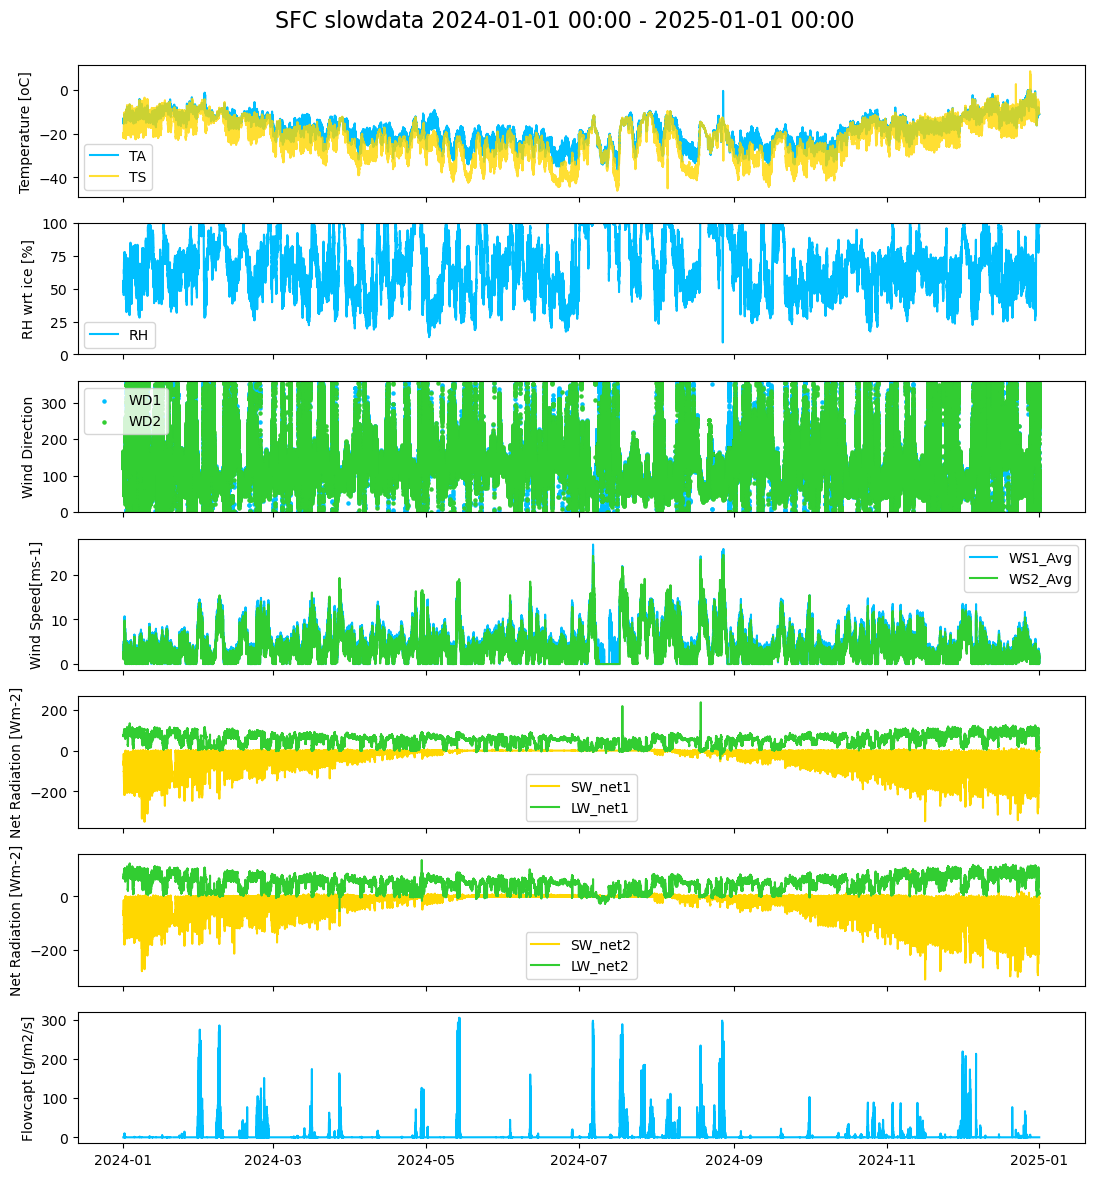

In [9]:
folder='/run/user/72637/gvfs/smb-share:server=memobi.wsl.ch,share=pub/Turbulence/PEA/Season_2024-2025/DATA/MET/converted/'
folder='/home/engbers/Documents/PhD/EC_data_convert/converted/'
sensor='SFC'
start='2024-01-01 00:00'
end='2025-01-01 00:00'

"""GET SENSOR INFO"""
plim, calibration_coefficients, heights = get_sensor_info(sensor, 2024)

"""READ FAST AND SLOW DATA from folder"""
slowdata=read_data(folder, 'slow', sensor, start, end, plot_data=False)

"""CLEAN SLOWDATA"""
slowdata_cleaned=clean_slowdata(slowdata)
plot_SFC_slowdata(slowdata_cleaned, sensor, start, end)

/home/engbers/Documents/Github/DataProcessingScripts/plotting/Funcs_plots.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_data = data.resample(resample_time).mean()
/home/engbers/Documents/Github/DataProcessingScripts/plotting/Funcs_plots.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  valid_counts = data.resample(resample_time).count()
/home/engbers/Documents/Github/DataProcessingScripts/plotting/Funcs_plots.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  total_counts = data.resample(resample_time).size()
/home/engbers/Documents/Github/DataProcessingScripts/plotting/Funcs_plots.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_data = data.resample(resample_time).mean()
/home/engbers/Documents/Github/DataProcessingScripts/plotting/Funcs

(<Figure size 1300x1800 with 9 Axes>,
 array([<Axes: ylabel='Temperature [oC]'>, <Axes: ylabel='RH wrt ice [%]'>,
        <Axes: ylabel='Wind Direction'>,
        <Axes: ylabel='Wind Speed [ms-1]'>,
        <Axes: ylabel='Net Radiation [Wm-2]'>, <Axes: ylabel='HS_Cor [m]'>,
        <Axes: ylabel='Flowcapt [g/m2/s]'>, <Axes: ylabel='H [Wm-2]'>,
        <Axes: ylabel='LE [Wm-2]'>], dtype=object))

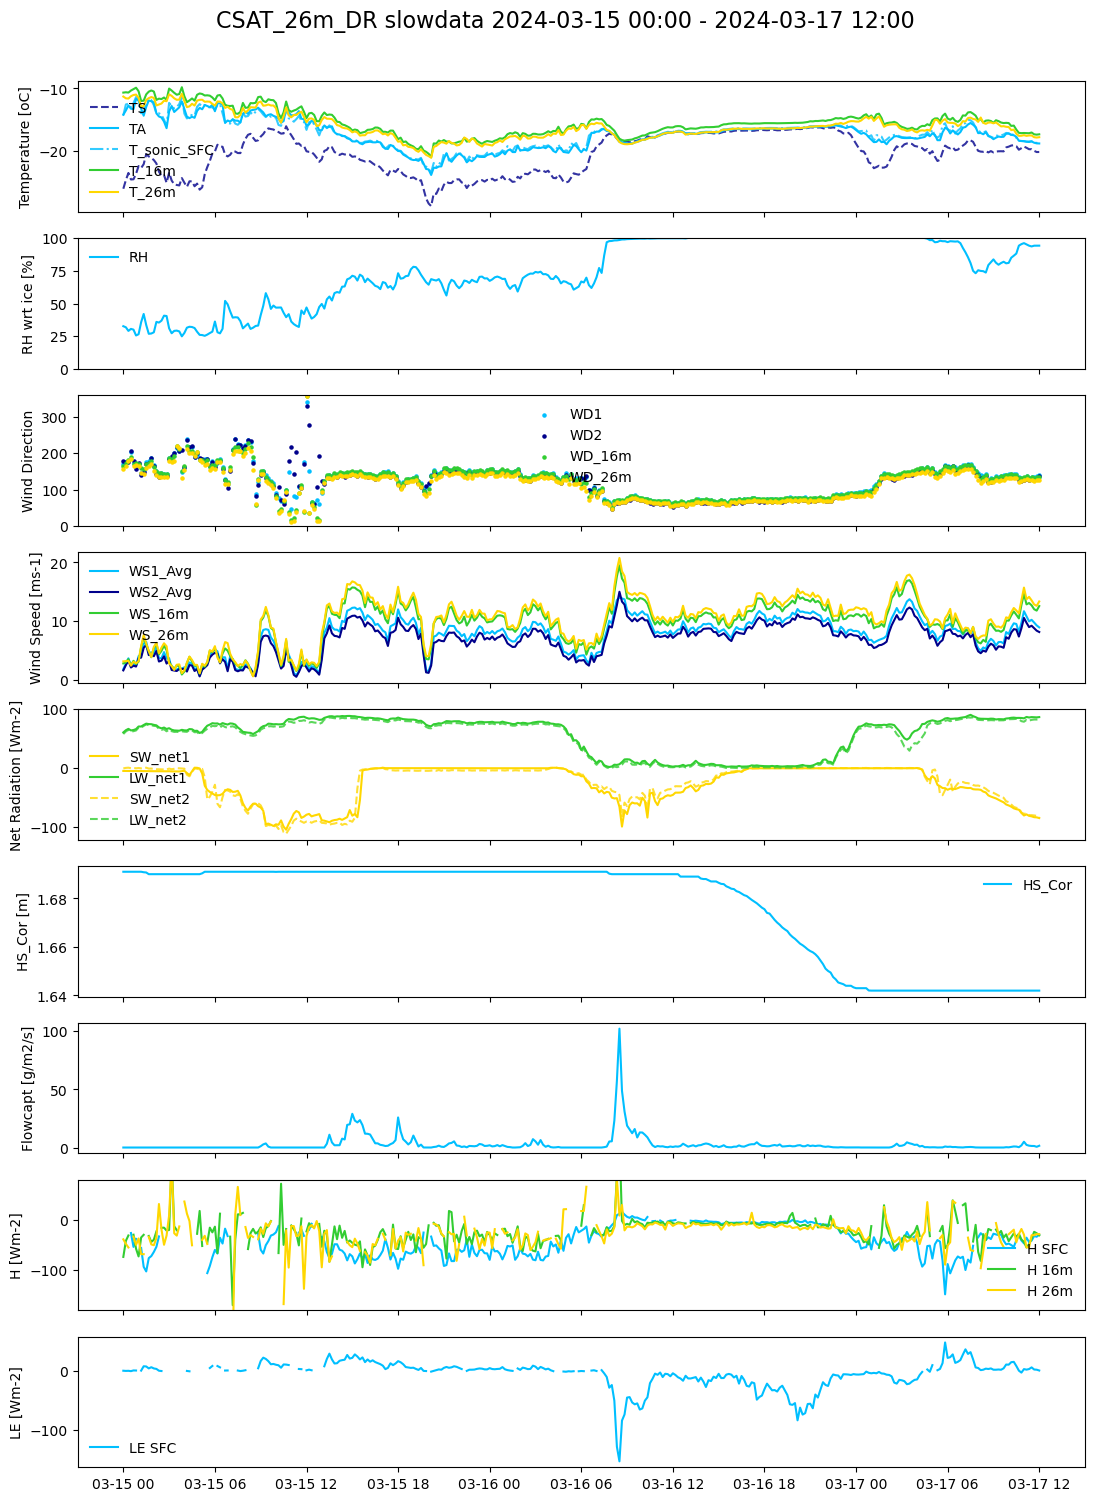

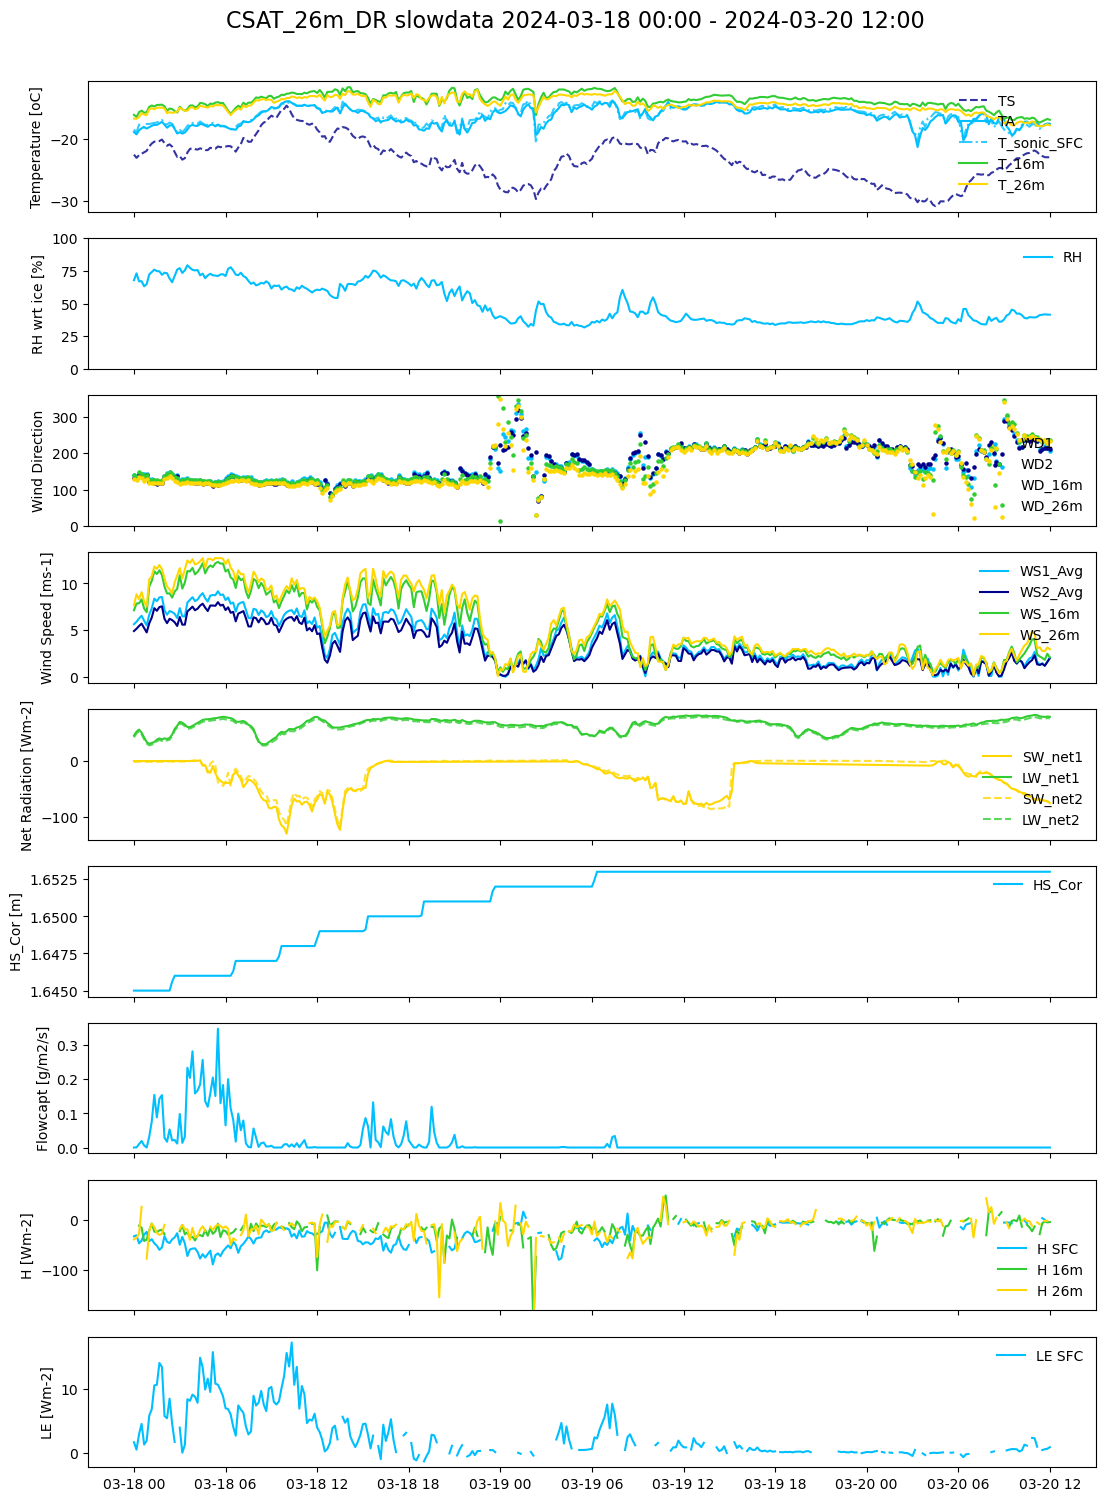

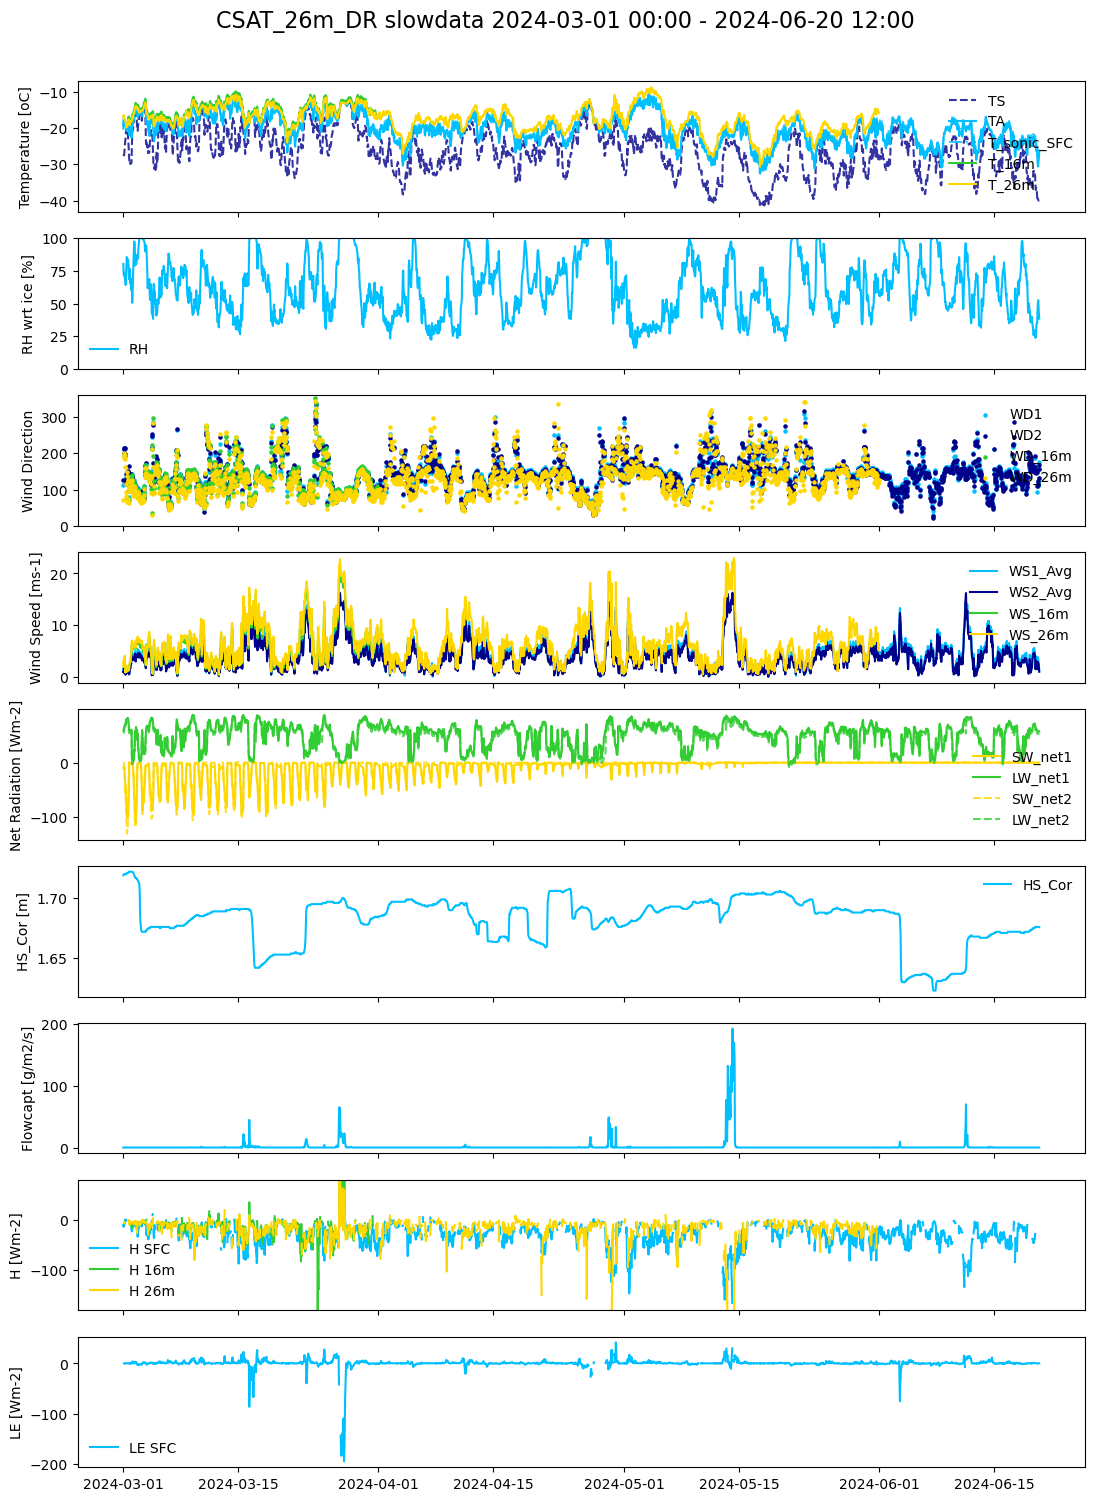

In [49]:
"""PLOT SLOWDATA AND FLUXES"""
start='2024-03-15 00:00'
end='2024-03-17 12:00'
plot_SFC_slowdata_and_fluxes(slowdata_cleaned, fluxes_SFC, fluxes_16m, fluxes_26m, sensor, start, end, resample_time='10min')

start='2024-03-18 00:00'
end='2024-03-20 12:00'
plot_SFC_slowdata_and_fluxes(slowdata_cleaned, fluxes_SFC, fluxes_16m, fluxes_26m, sensor, start, end, resample_time='10min')

start='2024-03-01 00:00'
end='2024-06-20 12:00'
plot_SFC_slowdata_and_fluxes(slowdata_cleaned, fluxes_SFC, fluxes_16m, fluxes_26m, sensor, start, end, resample_time='1h')

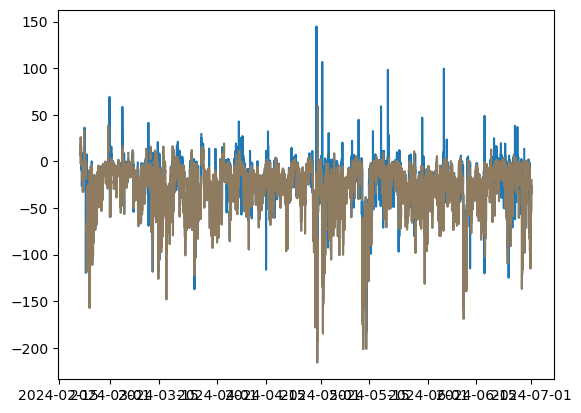

In [46]:
def resample_with_threshold(data, resample_time, min_valid_percent=80):
    """
    Returns NaN if the percentage of valid values within the resample time is less than min_valid_percent.

    Parameters:
        data (pd.Series): The input data to be resampled.
        resample_time (str): The resampling frequency (e.g., '10min', '1H').
        min_valid_percent (float): Minimum percentage of valid values required to keep the resampled value.

    Returns:
        pd.Series: The resampled data with insufficient valid data set to NaN.
    """
    # Resample the data
    resampled_data = data.resample(resample_time).mean()
    # Count the number of valid (non-NaN) values in each resample period
    valid_counts = data.resample(resample_time).count()
    # Calculate the total number of values in each resample period
    total_counts = data.resample(resample_time).size()
    # Calculate the percentage of valid values
    valid_percent = (valid_counts / total_counts) * 100
    # Apply the threshold and valid percentage filter
    filtered_data = resampled_data.where((valid_percent >= min_valid_percent))
    return filtered_data
plt.plot(fluxes_SFC['H'].resample('10min').mean())
plt.plot(resample_with_threshold(fluxes_SFC['H'], '10min'), alpha=0.5)

In [12]:
fluxes_16m

,Tau,qc_Tau,H,qc_H,H_strg,sonic_temperature,air_temperature,air_pressure,air_density,air_heat_capacity,...,non_steady_wind_hf,u_spikes,v_spikes,w_spikes,ts_spikes,u_var,v_var,w_var,ts_var,w/ts_cov
datetime,,,,,,,,,,,,,,,,,,,,,
2024-03-01 12:00:00,-0.005460,1.0,NaN,2.0,NaN,254.125,254.125,85588.4,1.17334,1005.00,...,89.0,0.0,0.0,0.0,0.0,0.013959,0.122395,0.000655,0.005971,0.000115
2024-03-01 12:10:00,0.001469,1.0,-0.843783,1.0,6.699780,254.338,254.338,85588.4,1.17236,1005.01,...,89.0,0.0,0.0,0.0,0.0,0.029657,0.004558,0.000661,0.014471,-0.000702
2024-03-01 12:20:00,-0.000465,1.0,-0.327265,0.0,8.723580,254.616,254.616,85588.4,1.17108,1005.01,...,89.0,0.0,0.0,0.0,0.0,0.013902,0.021231,0.001145,0.003167,-0.000271
2024-03-01 12:30:00,0.001148,1.0,NaN,2.0,-2.776070,254.528,254.528,85588.4,1.17149,1005.01,...,89.0,0.0,0.0,0.0,0.0,0.021107,0.004916,0.001178,0.002693,-0.000020
2024-03-01 12:40:00,0.000384,0.0,-0.242684,0.0,0.167282,254.533,254.533,85588.4,1.17146,1005.01,...,89.0,0.0,0.0,0.0,0.0,0.005486,0.006017,0.001134,0.004514,-0.000199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01 15:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-01 15:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-01 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
def compute_roughness_length(eddypro_data, eddypro_qc, z_wind):
    """This function computes the roughness length from the wind speed profile and ustar."""
    eddypro_data = eddypro_data.copy()
    eddypro_data = eddypro_data.resample('10min').mean()
    k = 0.4
    u_mean = eddypro_data['wind_speed']
    u_star = eddypro_data['u*']
    z0 = z_wind * np.exp(-k * u_mean / u_star)
    
    # Set z0 to NaN when (z-d)/L is not neutral
    z0[(eddypro_data['(z-d)/L'] < -0.1) | (eddypro_data['(z-d)/L'] > 0.1)] = np.nan
    # z0[(eddypro_qc['flag(u)'])]
    z0rolling = z0.rolling(window='28D', center=True, min_periods=1).median()

    return z0, z0rolling


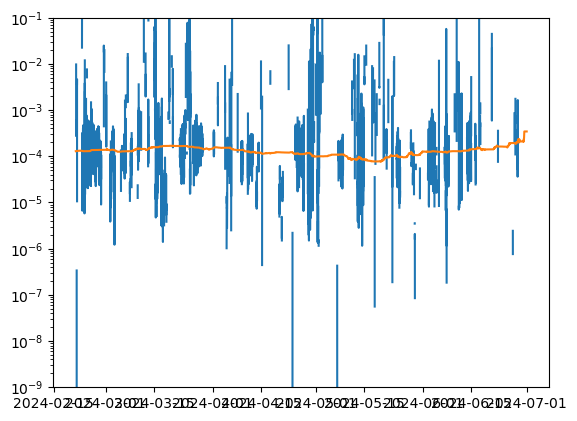

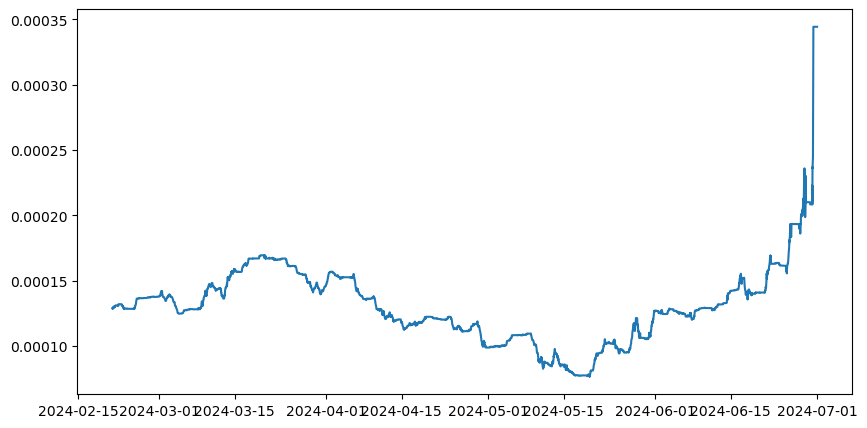

In [25]:
z0, z0rolling=compute_roughness_length(fluxes_SFC, fluxes_SFC_qc, 1.5)
plt.plot(z0)
plt.plot(z0rolling, label='z0 rolling median')
plt.yscale('log')
plt.ylim(1e-9, 1e-1)
plt.figure(figsize=(10, 5))
plt.plot(z0rolling, label='z0 rolling median')

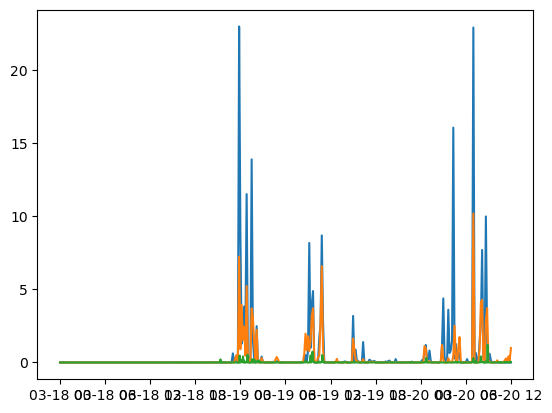

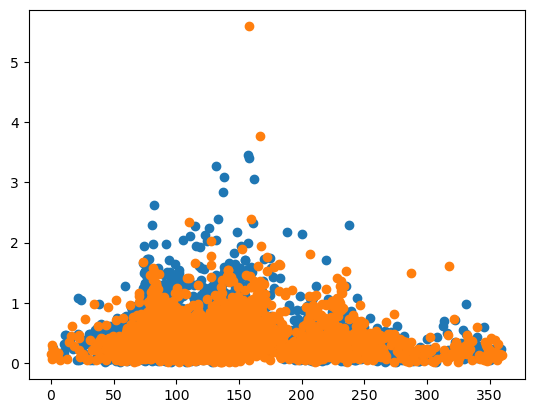

In [37]:

def solve_z0_logwindprofile(z, u, ustar, k=0.4):
    """
    Calculate z0 from the log wind profile equation.
    """
    return z*np.exp(-k*u/ustar)

# Ensure the DatetimeIndex is
fluxes_SFC = fluxes_SFC.sort_index()

# Plot the result
plt.plot(solve_z0_logwindprofile(26, fluxes_26m['wind_speed'][start:end], fluxes_26m['u*'][start:end]))
plt.plot(solve_z0_logwindprofile(16, fluxes_16m['wind_speed'][start:end], fluxes_16m['u*'][start:end]))

plt.plot(solve_z0_logwindprofile(2, fluxes_SFC['wind_speed'][start:end], fluxes_SFC['u*'][start:end]))

plt.figure()
plt.scatter( fluxes_26m['wind_dir'], fluxes_26m['w_var']/ fluxes_26m['u*'], label='SFC')
plt.scatter( fluxes_16m['wind_dir'], fluxes_16m['w_var']/ fluxes_16m['u*'], label='SFC')

# fluxes_SFC.columns

In [ ]:
def rolling_median(data, column_name='HS_Cor', window='1D', max_value=None):
    """
    Function to despike snow height data using a one-day moving median filter.
    
    Parameters:
    - data (pd.DataFrame): The input DataFrame containing snow height data.
    - column_name (str): The name of the column containing snow height data.
    
    Returns:
    - pd.Series: The despiked snow height data.
    """
    if column_name not in data.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")
    
    # Apply a one-day moving median filter
    median_filtered = data[column_name].rolling(window=window, center=True, min_periods=1).median()
    if max_value is not None:
        # Remove values above 2m
        median_filtered[median_filtered > max_value] = np.nan
        # Interpolate NaN values
        median_filtered = median_filtered.interpolate(method='linear', limit_direction='both')
    return median_filtered

In [21]:
import glob
folder='/home/engbers/Documents/PhD/EC_data_convert/SFC/202403/'
fastdata_list = []
units_metadata = {}

for file in sorted(glob.glob(folder + '*.dat')):
    temp_data = pd.read_csv(
        file,
        sep='\t',
        index_col=0,
        header=0,
        low_memory=False,
        na_values=['NaN'])
    temp_data.index = pd.to_datetime(temp_data.index, errors='coerce', format='mixed')
    dropped_row = temp_data.iloc[0]  # Extract the first row as metadata
    temp_data = temp_data.iloc[1:]  # Remove the first row from the data
    units_metadata[file] = dropped_row.to_dict()  # Store metadata in a dictionary
    
    # Convert all columns to numeric
    temp_data = temp_data.apply(pd.to_numeric, errors='coerce')
    
    fastdata_list.append(temp_data)  # Add the cleaned DataFrame to the list

# Concatenate all DataFrames in the list into a single DataFrame
fastdata = pd.concat(fastdata_list, ignore_index=False)

# Print the resulting DataFrame
print(fastdata)

                              Ux       Uy       Uz        Ts  LI_H2Om  LI_Pres
2024-03-01 00:00:00.000  0.48250 -2.40475  0.21900 -20.63008     35.9   1831.0
2024-03-01 00:00:00.100  0.24375 -2.55500  0.21825 -20.75847     36.6   1805.0
2024-03-01 00:00:00.200  0.18450 -2.35725  0.08550 -20.63641     36.4   1834.0
2024-03-01 00:00:00.300  0.45625 -2.39325  0.15050 -20.66336     36.1   1860.0
2024-03-01 00:00:00.400  0.66725 -2.33725  0.10750 -20.62689     36.1   1829.0
...                          ...      ...      ...       ...      ...      ...
2024-03-31 23:59:59.500  1.15900 -3.25900  0.14600 -22.77211     20.6   2065.0
2024-03-31 23:59:59.600  1.34400 -3.01650 -0.00975 -22.53528     20.7   2065.0
2024-03-31 23:59:59.700  1.12675 -2.96000 -0.05600 -22.51001     21.2   2089.0
2024-03-31 23:59:59.800  0.71775 -2.75525 -0.08900 -22.49261     20.9   2091.0
2024-03-31 23:59:59.900  1.11875 -2.67950 -0.04650 -22.50684     21.1   2065.0

[26784000 rows x 6 columns]


In [22]:
"""DOUBLE ROTATE THE DATA TO ALIGN WIND VECTOR WITH X-AXIS"""
fastdata_rot, angles=double_rotation(fastdata)


Double rotation for blocks of 0 days 00:30:00


/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaps = pd.concat([gaps, pd.DataFrame({'idx_before_gap': [len(data)],


MRD for DataFrame
Number of gaps: 1


 88%|████████▊ | 878169/1000000 [09:43<01:20, 1504.87it/s]


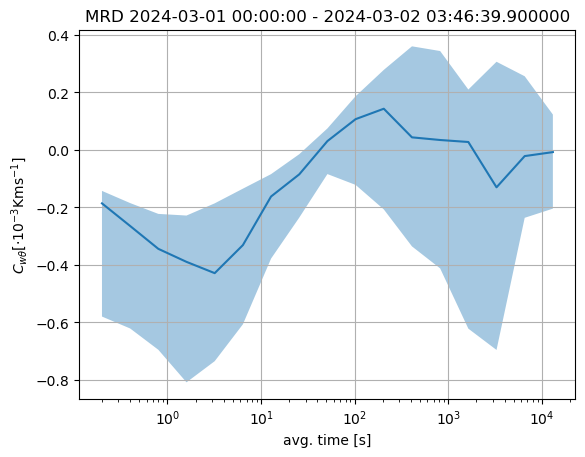

In [5]:
"""DO MRD TO CHECK AVERAGING TIME"""
M=17
(mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot[0:1000000], 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

MRD for DataFrame
Number of gaps: 1


 88%|████████▊ | 878169/999999 [08:24<01:10, 1739.83it/s]


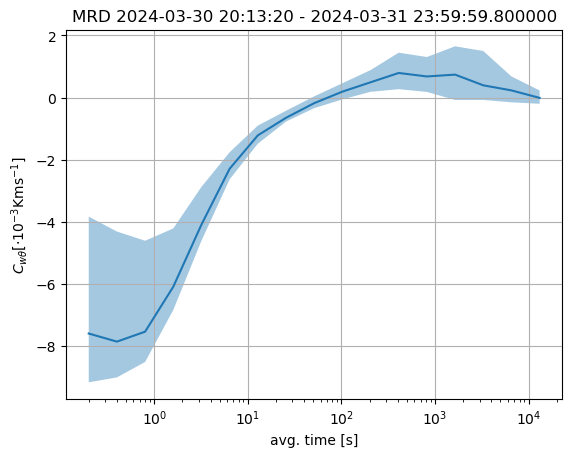

In [6]:
"""DO MRD TO CHECK AVERAGING TIME"""
M=17
(mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot[-1000000:-1], 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaps = pd.concat([gaps, pd.DataFrame({'idx_before_gap': [len(data)],


MRD for DataFrame
Number of gaps: 1


 92%|█████████▏| 1376235/1500000 [20:17<01:49, 1130.60it/s]


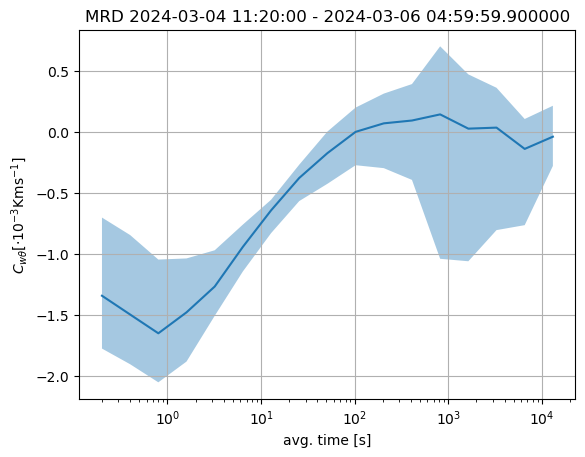

In [23]:
"""DO MRD TO CHECK AVERAGING TIME"""
M=17
(mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot[3000000:4500000], 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

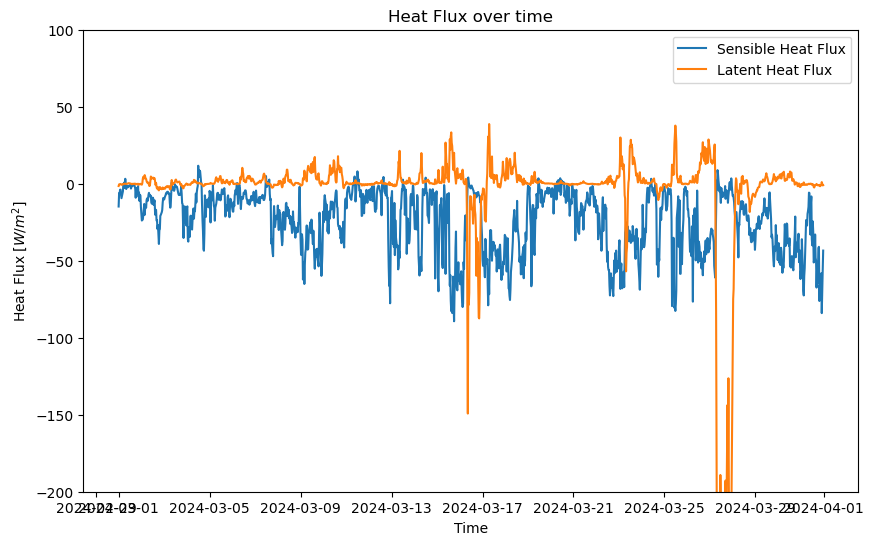

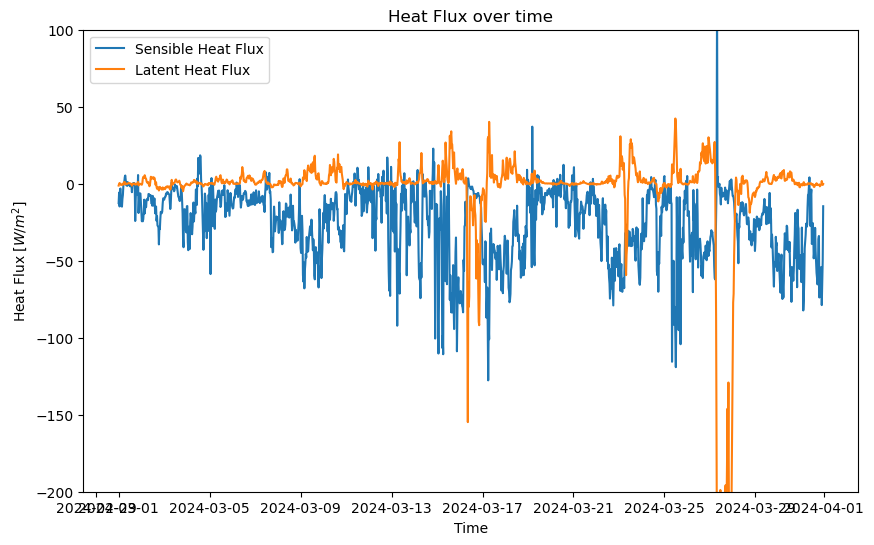

In [13]:
""" CHECK HEATFLUX QUICKLY WITH AVERAGING INTERVAL FOM MRD"""
df_heatflux=check_heat_flux(fastdata_rot, '30s', plot=True)
df_heatflux=check_heat_flux(fastdata_rot, '10min', plot=True)